# Download and extract the data

In [1]:
!wget https://goo.gl/8hY5ER
!tar xf 8hY5ER

--2018-11-06 18:23:21--  https://goo.gl/8hY5ER
Resolving goo.gl (goo.gl)... 172.217.7.142, 2607:f8b0:4004:802::200e
Connecting to goo.gl (goo.gl)|172.217.7.142|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz [following]
--2018-11-06 18:23:21--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘8hY5ER’

8hY5ER              100%[===================>]   5.61G  18.4MB/s    in 5m 51s  

2018-11-06 18:29:14 (16.4 MB/s) - ‘8hY5ER’ saved [6023741708/6023741708]



In [2]:
!ls UrbanSound8K/audio/

fold1  fold10  fold2  fold3  fold4  fold5  fold6  fold7  fold8	fold9


The folder structure contains 10 predefined validation folds.
According to the creators of the data set, you should evaluate with the provided folds and not reshuffle.

"Don't evaluate just on one split! Use 10-fold (not 5-fold) cross validation and average the scores
We have seen reports that only provide results for a single train/test split, e.g. train on folds 1-9, test on fold 10 and report a single accuracy score. We strongly advise against this. Instead, perform 10-fold cross validation using the provided folds and report the average score.

Why?
Not all the splits are as "easy". That is, models tend to obtain much higher scores when trained on folds 1-9 and tested on fold 10, compared to (e.g.) training on folds 2-10 and testing on fold 1. For this reason, it is important to evaluate your model on each of the 10 splits and report the average accuracy.
Again, your results will NOT be comparable to previous results in the literature."

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import os
import glob
import shutil
import IPython
import random
from collections import OrderedDict
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import librosa
import librosa.display
from pathlib import Path 
from fastai.imports import *
from fastai.conv_learner import *
from fastai.plots import *
from fastai.sgdr import *
from fastai.transforms import *

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Data Exploration and Exploratory Visualization

First let's look at the metadata of the dataset, to get an understanding of how the data is organized.

In [60]:
df = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')

In [61]:
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


The meta-data contains 8 columns:

* slice_file_name: name of the audio file
* fsID: FreesoundID of the recording where the excerpt is taken from
* start: start time of the slice
* end: end time of the slice
* salience: salience rating of the sound. 1 = foreground, 2 = background
* fold: The fold number (1-10) to which this file has been allocated
* classID:
       - 0 = air_conditioner
       - 1 = car_horn
       - 2 = children_playing
       - 3 = dog_bark
       - 4 = drilling
       - 5 = engine_idling
       - 6 = gun_shot
       - 7 = jackhammer
       - 8 = siren
       - 9 = street_music
* class: class name

The audio data has been already sliced and excerpted and even allocated to 10 different folds. Some of the excerpts are from the same original file but different slice. If one slice from a certain recording was in training data, and a different slice from the same recording was in test data, this might increase the accuracy of a final model falsely. Thanks to the original research, this has also been taken care of by allocating slices into folds such that all slices originating from the same Freesound recording go into the same fold.


Now let's get the class corresponding to various classID's. We will be using an OrderedDict to do this, as it will preserve the ordering of the classes in the dictionary.

In [62]:
classes = OrderedDict(sorted(df.set_index('classID').to_dict()['class'].items()))
classes

OrderedDict([(0, 'air_conditioner'),
             (1, 'car_horn'),
             (2, 'children_playing'),
             (3, 'dog_bark'),
             (4, 'drilling'),
             (5, 'engine_idling'),
             (6, 'gun_shot'),
             (7, 'jackhammer'),
             (8, 'siren'),
             (9, 'street_music')])

Extract the labels for all the classes.

In [6]:
labels = list(classes.values())

Next, let's have a look at the balance of the dataset.

Text(0.5,1,'Class distribution in the dataset')

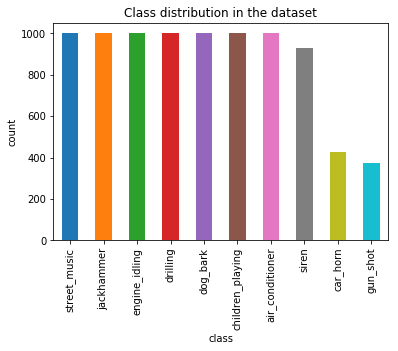

In [11]:
df.groupby('class').classID.count().sort_values(ascending=False).plot.bar()
plt.ylabel('count')
plt.title('Class distribution in the dataset')

There are two classes (car_horn & gun_shot) which have a bit less than half amount of entries compared to other 8 classes. But it doesn't look like the dataset is severely unbalanced, so we will not consider any data augmentation for these two minority classes.

Next, let's look at the length of the audio samples

Text(0.5,1,'Length of samples')

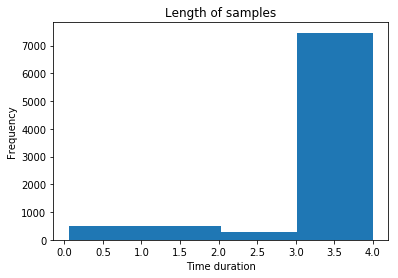

In [12]:
(df.end - df.start).plot.hist(bins=4)
plt.xlabel('Time duration')
plt.title('Length of samples')

The histogram above shows that most of the samples are of 3-4 seconds, which fits well with our planned spectrogram method of classification.

Next, let's look at the number of samples in each fold.

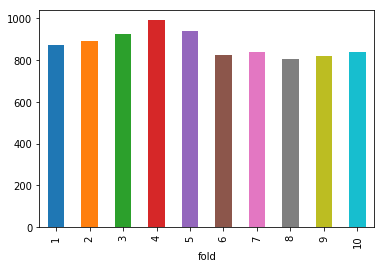

In [13]:
df.groupby('fold').count()['class'].plot.bar()

The audio sample distribution in each fold is consistent.

# Preprocessing the data and creating spectrograms

Let's create a new folder which will contain the images processed from the audio files.

In [14]:
!mkdir 'UrbanSound8K/spectrogram'

We will be using the librosa library to convert the audio files to their respective spectrograms. Librosa’s load function, by default, will convert the sampling rate to 22.05khz, as well as reducing the number of channels to 1(mono), and normalise the data so that the values will range from -1 to 1, which ensures that the spectrograms will be of uniform quality and can be used directly in models for classification.

In [6]:
def create_fold_spectrograms(fold):
    '''
    Function to read audio files from a folder and then convert and save 
    them into a different folder
    
    fold: int, the fold from which file is to be read
    '''
    spectrogram_path = Path('UrbanSound8K/spectrogram/')  
    audio_path = Path('UrbanSound8K/audio/')  
    print(f'Processing fold {fold}')
    os.mkdir(spectrogram_path/fold)
    
    for audio_file in list(Path(audio_path/f'fold{fold}').glob('*.wav')):
        # Load the audio file as a waveform, store its sampling rate
        samples, sample_rate = librosa.load(audio_file)
        
        # Define the dimensions of the spectrogram to be saved
        fig = plt.figure(figsize=[0.72,0.72])
        ax = fig.add_subplot(111)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)
        
        # Converted filename will be same as original file, with a different extension
        filename  = spectrogram_path/fold/Path(audio_file).name.replace('.wav','.png')
        
        # Compute the mel-scaled spectrogram for the sample
        S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
        
        # Convert the scaling of the spectrogram to dB units
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
        
        # Save the converted image 
        plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
        
        # Close the open image
        plt.close('all')

In [7]:
for i in range(1, 11):
    create_fold_spectrograms(str(i))

Processing fold 9
Processing fold 10


We'll be using fastai libraries for classification model training, and so, let's create an ImageNet style directory structure for each of the folds for easy data loading.

In [13]:
!mkdir 'UrbanSound8K/data'

mkdir: cannot create directory ‘UrbanSound8K/data’: File exists


In [9]:
data_path = Path('UrbanSound8K/data/') 
spectrogram_path = Path('UrbanSound8K/spectrogram/')  
def create_fold_directory(fold):
    """
    Function to create folder directories as per the ImageNet style for easier data loading
    """
    png_files =  list(Path(spectrogram_path/fold).glob('*.png'))
    
    # Make the new folders
    os.mkdir(data_path/fold)
    os.mkdir(data_path/fold/'train')
    os.mkdir(data_path/fold/'valid')
    for label in labels:
        os.mkdir(data_path/fold/'train'/label)
        os.mkdir(data_path/fold/'valid'/label)
    
    # Create the validaion set folder
    for file in png_files:
        label = file.as_posix().split('-')[1]
        shutil.copyfile(file, data_path/fold/'valid'/labels[int(label)]/file.name)   
    
    # Create the training set folder
    for i in range(1, 11):       
        if str(i) == fold:
            continue
        png_files =  list(Path(spectrogram_path/str(i)).glob('*.png'))
        for file in png_files:
            label = file.as_posix().split('-')[1]
            shutil.copyfile(file, data_path/fold/'train'/labels[int(label)]/file.name) 

In [10]:
for i in range(1, 11):
    create_fold_directory(str(i))

Next, let's visualize some of the converted spectrograms.

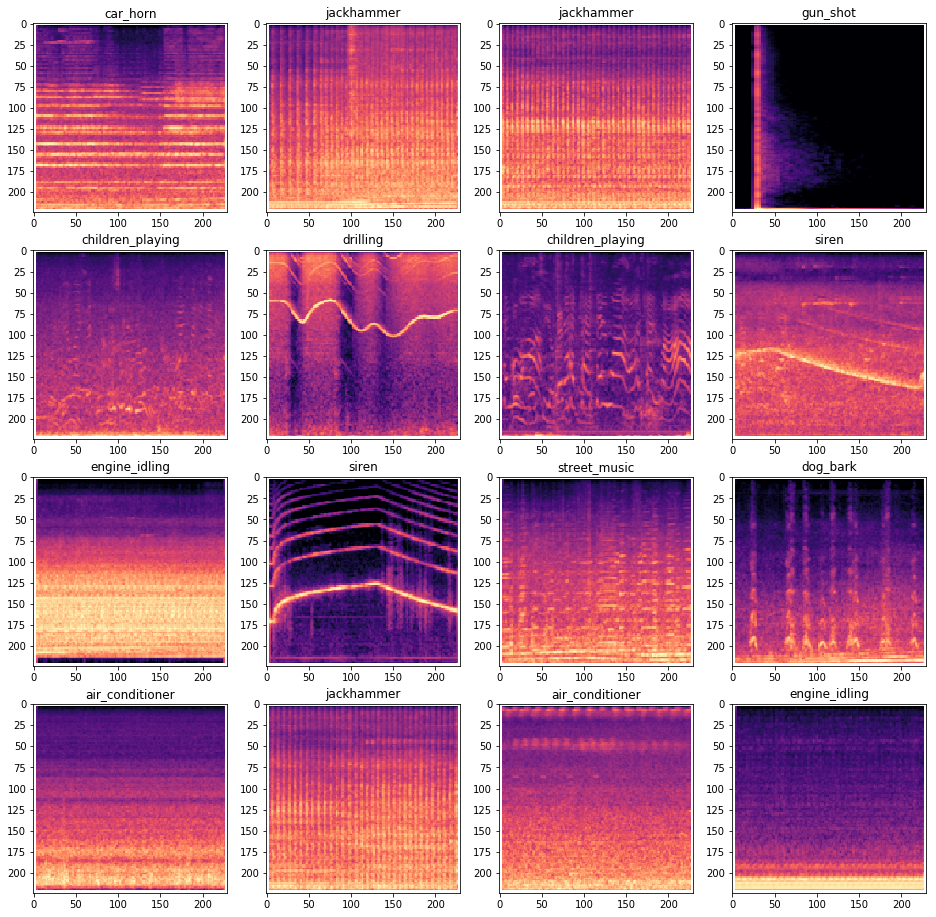

In [8]:
fig, ax = plt.subplots(4,4, figsize=(16,16))
for i in range(4):
    for j in range(4):
        rand = random.choice(os.listdir('UrbanSound8K/spectrogram/1/'))
        img = plt.imread('UrbanSound8K/spectrogram/1/'+ rand)
        label = classes[int(rand.split('-')[1])]
        ax[i][j].imshow(img)
        ax[i][j].set_title(label)

# Model Creation

### Base Benchmark Model

We will be using transfer learning for the purpose of Classification and will be using the Resnet34 architecture. For the benchmark model, we will be using a vanilla (untuned) Resnet34 architecture trained for 2 epochs. 

In [4]:
# Define the image size and architecture we want to use
sz = 224
arch = resnet34

# Define the data directory
data_directory = Path('UrbanSound8K/data')

In [6]:
def get_data(sz, PATH, bs=64):
    tfms = tfms_from_model(arch, sz=sz, aug_tfms=[])
    return ImageClassifierData.from_paths(PATH, bs=bs, tfms = tfms, val_name='valid')

Let's first run a simple model on the first fold set, so as to determine the number of epochs the training loop should be run.

In [20]:
data = get_data(sz, data_directory/'1')
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-4, 15 , cycle_len = 1)

/home/nbuser/courses/fastai/courses/dl1/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


  1%|          | 1/123 [00:00<00:54,  2.25it/s, loss=tensor(2.8559, device='cuda:0')]

/home/nbuser/courses/fastai/courses/dl1/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


epoch      trn_loss   val_loss   accuracy                                              
    0      2.660685   2.35085    0.136569  
    1      2.448648   2.136429   0.245019                                              
    2      2.293018   1.964805   0.356272                                              
    3      2.149829   1.83609    0.425604                                              
    4      2.029775   1.723962   0.484266                                              
    5      1.94804    1.639219   0.512304                                              
    6      1.872589   1.567523   0.53762                                               
    7      1.801685   1.50596    0.553871                                              
    8      1.738744   1.458954   0.572844                                              
    9      1.695723   1.406029   0.585121                                              
    10     1.631329   1.369504   0.602488                                   

[1.265159, 0.6402167]

In [21]:
learn.fit(1e-4, 5 , cycle_len = 1)

  1%|          | 1/123 [00:00<00:59,  2.05it/s, loss=tensor(1.5707, device='cuda:0')]

/home/nbuser/courses/fastai/courses/dl1/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


epoch      trn_loss   val_loss   accuracy                                              
    0      1.476726   1.243094   0.646913  
    1      1.435412   1.223522   0.652494                                              
    2      1.396779   1.20607    0.655842                                              
    3      1.384231   1.195539   0.659816                                              
    4      1.378176   1.174686   0.673209                                              



[1.1746855, 0.67320883]

In [22]:
learn.fit(1e-4, 5 , cycle_len = 1)

  1%|          | 1/123 [00:00<00:56,  2.17it/s, loss=tensor(1.4527, device='cuda:0')]

/home/nbuser/courses/fastai/courses/dl1/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


epoch      trn_loss   val_loss   accuracy                                              
    0      1.348955   1.16441    0.669861  
    1      1.354514   1.15186    0.66379                                               
    2      1.334686   1.134167   0.671603                                              
    3      1.305578   1.120454   0.678299                                              
    4      1.282892   1.117634   0.680531                                              



[1.117634, 0.6805314]

We don't see much improvement in the last few epochs of training, with only 0.2% improvement in accuracy, so let's run the untuned CNN model for 25 epochs each for the different folds and get the base accuracy value.

In [23]:
def process_fold_simple(fold):
    data = get_data(sz, data_directory/fold)
    learn = ConvLearner.pretrained(arch, data, precompute=True)
    m = learn.fit(1e-4, 25 , cycle_len = 1)
    return m, learn

Let's process each fold through a loop.

In [24]:
metric_simple = []
for i in range(1,11):
    print('--------Fold {} -----------'.format(i))
    m, learn = process_fold_simple(str(i))
    metric_simple.append(m)
    learn.save('Simple_CNN_model_'+ str(i))

--------Fold 1 -----------


/home/nbuser/courses/fastai/courses/dl1/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


  1%|          | 1/123 [00:00<01:02,  1.96it/s, loss=tensor(2.8263, device='cuda:0')]

/home/nbuser/courses/fastai/courses/dl1/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


epoch      trn_loss   val_loss   accuracy                                              
    0      2.633538   2.330446   0.17868   
    1      2.422052   2.088992   0.258684                                              
    2      2.258568   1.905753   0.360382                                              
    3      2.101464   1.761383   0.421766                                              
    4      1.972723   1.644814   0.479938                                              
    5      1.87114    1.551187   0.510562                                              
    6      1.807674   1.484622   0.550876                                              
    7      1.744016   1.420816   0.58052                                               
    8      1.681604   1.38773    0.590565                                              
    9      1.643585   1.334025   0.601236                                              
    10     1.579219   1.296047   0.622577                                   

epoch      trn_loss   val_loss   accuracy                                              
    0      2.702779   2.36673    0.128508  
    1      2.451523   2.156471   0.200893                                              
    2      2.251042   2.006831   0.264031                                              
    3      2.093426   1.87966    0.331314                                              
    4      1.97625    1.786452   0.396365                                              
    5      1.894817   1.708119   0.435906                                              
    6      1.785968   1.648638   0.466837                                              
    7      1.732691   1.594739   0.500797                                              
    8      1.660823   1.540733   0.522003                                              
    9      1.609536   1.507764   0.539062                                              
    10     1.569984   1.473877   0.54815                                    

epoch      trn_loss   val_loss   accuracy                                              
    0      2.608654   2.308257   0.189799  
    1      2.405157   2.124748   0.255424                                              
    2      2.23026    1.98542    0.309806                                              
    3      2.066899   1.861554   0.35273                                               
    4      1.95039    1.778811   0.395043                                              
    5      1.883837   1.688776   0.428807                                              
    6      1.803054   1.633113   0.460273                                              
    7      1.720432   1.583576   0.481106                                              
    8      1.65658    1.53543    0.488398                                              
    9      1.592639   1.484864   0.504238                                              
    10     1.563407   1.469056   0.522378                                   

epoch      trn_loss   val_loss   accuracy                                              
    0      2.563062   2.18414    0.209049  
    1      2.426614   1.983845   0.294401                                              
    2      2.244789   1.844533   0.36569                                               
    3      2.10712    1.711385   0.415625                                              
    4      1.971038   1.633514   0.448828                                              
    5      1.888595   1.545835   0.46263                                               
    6      1.791472   1.485074   0.478971                                              
    7      1.71547    1.431039   0.505729                                              
    8      1.664781   1.380852   0.527344                                              
    9      1.61479    1.34682    0.536133                                              
    10     1.570337   1.315028   0.543945                                   

epoch      trn_loss   val_loss   accuracy                                              
    0      2.638572   2.28885    0.179792  
    1      2.429465   2.087306   0.266042                                              
    2      2.274087   1.926356   0.338125                                              
    3      2.128562   1.803046   0.380417                                              
    4      1.992333   1.70123    0.417083                                              
    5      1.888845   1.614412   0.467083                                              
    6      1.831957   1.548041   0.482917                                              
    7      1.758648   1.491578   0.503125                                              
    8      1.716469   1.436212   0.512917                                              
    9      1.65358    1.398674   0.531667                                              
    10     1.615899   1.365166   0.536042                                   

epoch      trn_loss   val_loss   accuracy                                              
    0      2.706201   2.347174   0.121372  
    1      2.494416   2.168014   0.208108                                              
    2      2.309871   2.017827   0.282802                                              
    3      2.16412    1.904378   0.342483                                              
    4      2.03535    1.821701   0.393947                                              
    5      1.912101   1.727445   0.435992                                              
    6      1.844546   1.663165   0.45542                                               
    7      1.766498   1.61137    0.467832                                              
    8      1.695773   1.576806   0.481053                                              
    9      1.630558   1.531911   0.502885                                              
    10     1.585451   1.496926   0.504087                                   

epoch      trn_loss   val_loss   accuracy                                              
    0      2.704963   2.41198    0.109375  
    1      2.463508   2.242422   0.167411                                              
    2      2.266014   2.092808   0.220982                                              
    3      2.162309   1.969692   0.266741                                              
    4      2.033316   1.883134   0.289062                                              
    5      1.926359   1.78947    0.323661                                              
    6      1.841177   1.726969   0.361235                                              
    7      1.78583    1.66417    0.369048                                              
    8      1.690328   1.604468   0.405506                                              
    9      1.645859   1.56387    0.430804                                              
    10     1.595049   1.527569   0.458705                                   

epoch      trn_loss   val_loss   accuracy                                              
    0      2.735883   2.342564   0.135121  
    1      2.497789   2.158961   0.195218                                              
    2      2.30255    2.004716   0.253353                                              
    3      2.163292   1.88374    0.299026                                              
    4      2.013375   1.78721    0.330276                                              
    5      1.904145   1.69358    0.377973                                              
    6      1.824737   1.632899   0.40081                                               
    7      1.75565    1.570049   0.446926                                              
    8      1.694504   1.520205   0.473368                                              
    9      1.629908   1.477585   0.497027                                              
    10     1.574136   1.435551   0.518282                                   

epoch      trn_loss   val_loss   accuracy                                              
    0      2.66968    2.30383    0.157452  
    1      2.482501   2.108096   0.239984                                              
    2      2.274659   1.956125   0.30609                                               
    3      2.117069   1.844414   0.354567                                              
    4      2.012528   1.750369   0.40625                                               
    5      1.909238   1.662661   0.444712                                              
    6      1.834283   1.611984   0.475561                                              
    7      1.754534   1.561145   0.495593                                              
    8      1.680119   1.525497   0.496394                                              
    9      1.636233   1.489873   0.51883                                               
    10     1.577013   1.438562   0.533253                                   

In [25]:
untuned_metrics = pd.DataFrame(metric_simple)

In [26]:
untuned_metrics[1].mean()

0.6230212807655334

In [27]:
untuned_metrics[1].std()

0.03484147016671532

In [28]:
untuned_accuracy = untuned_metrics[1].mean() + untuned_metrics[1].std()

In [29]:
untuned_accuracy

0.6578627509322488

### Tuned Resnet Model

In a similar way as above, let's work with a single fold initially to get the ideal training schedule for the CNN.

In [16]:
data = get_data(sz, data_directory/'1')
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-4, 3, cycle_len = 1)

/home/nbuser/courses/fastai/courses/dl1/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


  1%|          | 1/123 [00:00<00:59,  2.06it/s, loss=tensor(2.8765, device='cuda:0')]

/home/nbuser/courses/fastai/courses/dl1/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


epoch      trn_loss   val_loss   accuracy                                              
    0      2.690411   2.360142   0.132595  
    1      2.488005   2.106702   0.219294                                              
    2      2.284639   1.928208   0.303762                                              



[1.9282085, 0.303762]

In [17]:
learn.precompute = False
learn.fit(1e-4, 1, cycle_len = 1)

  1%|          | 1/123 [00:01<03:24,  1.68s/it, loss=tensor(2.2834, device='cuda:0')]

/home/nbuser/courses/fastai/courses/dl1/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


epoch      trn_loss   val_loss   accuracy                                              
    0      2.142876   1.806188   0.360818  



[1.8061875, 0.36081773]

In [18]:
learn.unfreeze()
learn.fit([1e-6,1e-5,1e-4], 3, cycle_len = 1, cycle_mult = 2)

  0%|          | 0/123 [00:00<?, ?it/s]

/home/nbuser/courses/fastai/courses/dl1/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


epoch      trn_loss   val_loss   accuracy                                              
    0      2.592478   2.216308   0.182682  
    1      2.401264   1.99689    0.291077                                              
    2      2.292684   1.973435   0.31465                                               
    3      2.154738   1.785023   0.42046                                               
    4      2.036301   1.674916   0.467607                                              
    5      1.943187   1.636249   0.4856                                                
    6      1.923874   1.627372   0.48051                                               



[1.6273724, 0.48050958]

In [19]:
learn.fit([1e-6,1e-5,1e-4], 3, cycle_len = 1)

  0%|          | 0/123 [00:00<?, ?it/s]

/home/nbuser/courses/fastai/courses/dl1/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


epoch      trn_loss   val_loss   accuracy                                              
    0      1.86103    1.57584    0.510644  
    1      1.816072   1.512961   0.524172                                              
    2      1.740575   1.467932   0.54663                                               



[1.4679315, 0.54663]

In [21]:
learn.fit(1e-4, 3, cycle_len = 1)

  0%|          | 0/123 [00:00<?, ?it/s]

/home/nbuser/courses/fastai/courses/dl1/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


epoch      trn_loss   val_loss   accuracy                                              
    0      1.581099   1.301384   0.597126  
    1      1.377739   1.167257   0.635834                                              
    2      1.207564   1.081283   0.639808                                              



[1.081283, 0.63980836]

In [22]:
learn.save('l')

In [23]:
learn.fit(1e-4, 3, cycle_len = 1)

  0%|          | 0/123 [00:00<?, ?it/s]

/home/nbuser/courses/fastai/courses/dl1/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


epoch      trn_loss   val_loss   accuracy                                              
    0      1.114134   1.003843   0.672801  
    1      1.004107   0.932346   0.688072                                              
    2      0.921256   0.895226   0.701954                                              



[0.8952259, 0.7019545]

In [26]:
learn.save('l')

In [25]:
learn.fit(1e-4, 4, cycle_len = 1)

  0%|          | 0/123 [00:00<?, ?it/s]

/home/nbuser/courses/fastai/courses/dl1/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


epoch      trn_loss   val_loss   accuracy                                              
    0      0.851475   0.866178   0.713115  
    1      0.80036    0.820146   0.721554                                              
    2      0.731333   0.790996   0.743521                                              
    3      0.679087   0.771427   0.750082                                              



[0.77142686, 0.75008166]

In [26]:
learn.save('l')

In [27]:
learn.fit(1e-4, 2, cycle_len = 1, cycle_mult = 2)

  0%|          | 0/123 [00:00<?, ?it/s]

/home/nbuser/courses/fastai/courses/dl1/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


epoch      trn_loss   val_loss   accuracy                                              
    0      0.629324   0.740956   0.751824  
    1      0.606575   0.718879   0.763611                                              
    2      0.556596   0.714313   0.755798                                              



[0.71431345, 0.75579816]

In [28]:
learn.save('l')

In [29]:
learn.fit(1e-4, 3, cycle_len = 1)

  0%|          | 0/123 [00:00<?, ?it/s]

/home/nbuser/courses/fastai/courses/dl1/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


epoch      trn_loss   val_loss   accuracy                                              
    0      0.538063   0.70217    0.763121  
    1      0.502256   0.709935   0.756288                                              
    2      0.479527   0.688997   0.749102                                              



[0.688997, 0.7491017]

This is where we first see that overfitting starts becoming an issue, as the validation loss started increasing while the training loss was decreasing.

Based on the above training schedule, let's define a training loop for all other folds.

In [3]:
def process_fold(fold):
    data = get_data(sz, data_directory/fold)
    learn = ConvLearner.pretrained(arch, data)
    learn.fit(1e-4, 3, cycle_len = 1)
    learn.unfreeze()
    learn.fit([1e-6,1e-5,1e-4], 3, cycle_len = 1, cycle_mult = 2)
    m = learn.fit(1e-4, 14, cycle_len = 1)
    return m, learn

Let's go through the folds using a for loop, storing the accuracy metric for each.

In [7]:
metric = []
for i in range(1,11):
    print('--------Fold {} -----------'.format(i))
    m, learn = process_fold(str(i))
    metric.append(m)
    learn.save('CNN_model_'+ str(i))

--------Fold 1 -----------


/home/nbuser/courses/fastai/courses/dl1/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


  1%|          | 1/123 [00:01<03:31,  1.73s/it, loss=tensor(2.9672, device='cuda:0')]

/home/nbuser/courses/fastai/courses/dl1/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


epoch      trn_loss   val_loss   accuracy                                              
    0      2.568456   2.296326   0.176802  
    1      2.387298   2.075346   0.254083                                              
    2      2.209651   1.886545   0.332344                                              



epoch      trn_loss   val_loss   accuracy                                              
    0      2.589406   2.332505   0.153718  
    1      2.447935   2.110043   0.219839                                              
    2      2.314383   2.063009   0.233232                                              
    3      2.179217   1.866951   0.317699                                              
    4      2.009823   1.737381   0.375381                                              
    5      1.918891   1.685686   0.393864                                              
    6      1.875452   1.683882   0.402793                                              



epoch      trn_loss   val_loss   accuracy                                              
    0      1.705469   1.453052   0.483286  
    1      1.467724   1.27111    0.556593                                              
    2      1.3019     1.163848   0.589095                                              
    3      1.156853   1.076781   0.612043                                              
    4      1.056462   1.000518   0.650125                                              
    5      0.957184   0.956757   0.664144                                              
    6      0.87       0.914666   0.673073                                              
    7      0.808501   0.867196   0.706691                                              
    8      0.749012   0.851171   0.700131                                              
    9      0.69098    0.82733    0.721826                                              
    10     0.656656   0.793301   0.734103                                   

epoch      trn_loss   val_loss   accuracy                                              
    0      2.73257    2.350557   0.15354   
    1      2.508717   2.153824   0.248884                                              
    2      2.333911   2.013003   0.32398                                               



epoch      trn_loss   val_loss   accuracy                                              
    0      2.66011    2.261034   0.172353  
    1      2.458129   2.027946   0.260364                                              
    2      2.346734   1.987382   0.281091                                              
    3      2.185548   1.806182   0.352519                                              
    4      2.044217   1.692208   0.415019                                              
    5      1.97525    1.649146   0.4375                                                
    6      1.955936   1.640003   0.438616                                              



epoch      trn_loss   val_loss   accuracy                                              
    0      1.707124   1.412134   0.533163  
    1      1.477567   1.249008   0.598055                                              
    2      1.27199    1.17233    0.594547                                              
    3      1.15257    1.087202   0.617825                                              
    4      1.054811   1.042113   0.635045                                              
    5      0.943561   1.019858   0.637755                                              
    6      0.856978   0.984369   0.640147                                              
    7      0.788149   0.938156   0.662946                                              
    8      0.739034   0.930629   0.659598                                              
    9      0.678814   0.883393   0.685587                                              
    10     0.638772   0.879948   0.685268                                   

epoch      trn_loss   val_loss   accuracy                                              
    0      2.654867   2.238556   0.195438  
    1      2.447858   2.058833   0.275251                                              
    2      2.270932   1.909412   0.359231                                              



epoch      trn_loss   val_loss   accuracy                                              
    0      2.629304   2.217368   0.194792  
    1      2.450474   2.01628    0.295007                                              
    2      2.332539   1.977992   0.304598                                              
    3      2.159351   1.823402   0.389224                                              
    4      2.003408   1.726419   0.421121                                              
    5      1.940362   1.700599   0.427586                                              
    6      1.893944   1.686576   0.43592                                               



epoch      trn_loss   val_loss   accuracy                                              
    0      1.690757   1.508806   0.503628  
    1      1.460205   1.349208   0.548851                                              
    2      1.290094   1.253118   0.571372                                              
    3      1.144546   1.183754   0.590769                                              
    4      1.031691   1.0812     0.634303                                              
    5      0.937373   1.024998   0.644325                                              
    6      0.870162   0.984001   0.672234                                              
    7      0.836718   0.937975   0.670977                                              
    8      0.750216   0.889825   0.706825                                              
    9      0.709628   0.867334   0.71329                                               
    10     0.656633   0.833825   0.728089                                   

epoch      trn_loss   val_loss   accuracy                                              
    0      2.699776   2.33914    0.168229  
    1      2.484123   2.100191   0.260286                                              
    2      2.295746   1.925419   0.343555                                              



epoch      trn_loss   val_loss   accuracy                                              
    0      2.64328    2.342409   0.147982  
    1      2.464251   2.157734   0.232227                                              
    2      2.361694   2.120713   0.240169                                              
    3      2.228247   1.955054   0.306445                                              
    4      2.040053   1.858777   0.366146                                              
    5      1.968907   1.81826    0.379102                                              
    6      1.939938   1.801932   0.388021                                              



epoch      trn_loss   val_loss   accuracy                                              
    0      1.731883   1.620204   0.46901   
    1      1.497235   1.433975   0.53431                                               
    2      1.309084   1.291179   0.584115                                              
    3      1.155068   1.183425   0.62526                                               
    4      1.050658   1.099734   0.662044                                              
    5      0.950637   1.041125   0.67474                                               
    6      0.879788   0.974342   0.678646                                              
    7      0.796917   0.937052   0.692188                                              
    8      0.740012   0.894292   0.710156                                              
    9      0.709039   0.856257   0.719662                                              
    10     0.672862   0.838802   0.722721                                   

epoch      trn_loss   val_loss   accuracy                                              
    0      2.584638   2.206332   0.220208  
    1      2.403472   1.985727   0.309792                                              
    2      2.225846   1.835323   0.38                                                  



epoch      trn_loss   val_loss   accuracy                                              
    0      2.633807   2.253318   0.200625  
    1      2.447263   2.050029   0.276458                                              
    2      2.339838   2.012052   0.2975                                                
    3      2.171595   1.85754    0.372083                                              
    4      2.015273   1.761695   0.405                                                 
    5      1.930492   1.71406    0.425833                                              
    6      1.88829    1.710326   0.418958                                              



epoch      trn_loss   val_loss   accuracy                                              
    0      1.728803   1.513624   0.51      
    1      1.472123   1.342133   0.572708                                              
    2      1.299704   1.228614   0.618542                                              
    3      1.157268   1.136116   0.638958                                              
    4      1.068591   1.0695     0.657292                                              
    5      0.974864   0.994098   0.672708                                              
    6      0.893597   0.94018    0.690417                                              
    7      0.830355   0.907045   0.700208                                              
    8      0.773781   0.847349   0.719792                                              
    9      0.733336   0.801277   0.750625                                              
    10     0.667728   0.777765   0.746458                                   

epoch      trn_loss   val_loss   accuracy                                              
    0      2.756845   2.263647   0.184856  
    1      2.498659   2.079965   0.258566                                              
    2      2.293878   1.942064   0.32205                                               



epoch      trn_loss   val_loss   accuracy                                              
    0      2.674909   2.350092   0.137194  
    1      2.476528   2.148911   0.219296                                              
    2      2.343418   2.103355   0.241324                                              
    3      2.19421    1.928384   0.326639                                              
    4      2.025478   1.82907    0.373711                                              
    5      1.954076   1.793219   0.398536                                              
    6      1.885101   1.782774   0.398929                                              



epoch      trn_loss   val_loss   accuracy                                              
    0      1.699058   1.601619   0.499869  
    1      1.458308   1.447334   0.555747                                              
    2      1.286972   1.343248   0.580376                                              
    3      1.129916   1.236457   0.615232                                              
    4      1.029358   1.187965   0.621045                                              
    5      0.920838   1.141512   0.635664                                              
    6      0.863915   1.097381   0.652688                                              
    7      0.79565    1.060932   0.661101                                              
    8      0.746002   1.021155   0.672312                                              
    9      0.695483   1.002089   0.676923                                              
    10     0.628614   0.994284   0.686538                                   

epoch      trn_loss   val_loss   accuracy                                              
    0      2.751148   2.402074   0.094866  
    1      2.521606   2.208984   0.169271                                              
    2      2.311316   2.062813   0.234003                                              



epoch      trn_loss   val_loss   accuracy                                              
    0      2.616172   2.287978   0.170759  
    1      2.400754   2.082178   0.254464                                              
    2      2.285396   2.044858   0.261161                                              
    3      2.147339   1.857394   0.37128                                               
    4      1.991383   1.766134   0.383929                                              
    5      1.904086   1.711164   0.434524                                              
    6      1.906832   1.715155   0.391741                                              



epoch      trn_loss   val_loss   accuracy                                              
    0      1.669538   1.474018   0.520089  
    1      1.429656   1.346274   0.556548                                              
    2      1.255287   1.240035   0.60119                                               
    3      1.092431   1.165509   0.611235                                              
    4      0.997113   1.118772   0.620536                                              
    5      0.915439   1.063279   0.651414                                              
    6      0.832612   1.010408   0.68006                                               
    7      0.768018   0.971191   0.678199                                              
    8      0.705082   0.930942   0.704613                                              
    9      0.665554   0.910211   0.715774                                              
    10     0.622937   0.88788    0.707961                                   

epoch      trn_loss   val_loss   accuracy                                              
    0      2.701794   2.264944   0.188322  
    1      2.458892   2.086331   0.256832                                              
    2      2.271648   1.930395   0.330149                                              



epoch      trn_loss   val_loss   accuracy                                              
    0      2.593227   2.25844    0.175544  
    1      2.423649   2.070276   0.257338                                              
    2      2.300472   2.030027   0.279795                                              
    3      2.155137   1.876283   0.335526                                              
    4      1.99159    1.782292   0.378859                                              
    5      1.928174   1.752181   0.394484                                              
    6      1.894584   1.747153   0.39771                                               



epoch      trn_loss   val_loss   accuracy                                              
    0      1.678215   1.590426   0.465967  
    1      1.473451   1.445006   0.53688                                               
    2      1.291467   1.348264   0.580972                                              
    3      1.154528   1.287043   0.605073                                              
    4      1.05403    1.208149   0.650367                                              
    5      0.983062   1.170818   0.655997                                              
    6      0.890645   1.125402   0.672824                                              
    7      0.823567   1.116891   0.674848                                              
    8      0.772126   1.076477   0.682439                                              
    9      0.703059   1.052893   0.686108                                              
    10     0.666953   1.043938   0.693699                                   

epoch      trn_loss   val_loss   accuracy                                              
    0      2.576853   2.271675   0.196715  
    1      2.37486    2.067554   0.310096                                              
    2      2.174599   1.917589   0.381811                                              



epoch      trn_loss   val_loss   accuracy                                              
    0      2.585346   2.209648   0.218349  
    1      2.368757   2.000996   0.320913                                              
    2      2.27925    1.948599   0.336939                                              
    3      2.128793   1.774176   0.410657                                              
    4      1.954094   1.665818   0.467949                                              
    5      1.887632   1.626297   0.467548                                              
    6      1.874297   1.621956   0.474359                                              



epoch      trn_loss   val_loss   accuracy                                              
    0      1.68566    1.406659   0.551683  
    1      1.433798   1.274397   0.607372                                              
    2      1.269163   1.166696   0.638622                                              
    3      1.121462   1.082642   0.665064                                              
    4      0.998708   1.015357   0.680689                                              
    5      0.926328   0.959916   0.691506                                              
    6      0.83619    0.922991   0.713542                                              
    7      0.771316   0.889211   0.727163                                              
    8      0.717233   0.859161   0.723157                                              
    9      0.668784   0.834952   0.738381                                              
    10     0.620322   0.806813   0.741587                                   

epoch      trn_loss   val_loss   accuracy                                              
    0      2.493142   2.139434   0.21317   
    1      2.345793   1.969901   0.295536                                              
    2      2.181631   1.82698    0.363616                                              



epoch      trn_loss   val_loss   accuracy                                              
    0      2.588006   2.134809   0.222098  
    1      2.414887   1.916634   0.322545                                              
    2      2.289509   1.866996   0.358036                                              
    3      2.158177   1.66774    0.466071                                              
    4      2.003356   1.582136   0.496205                                              
    5      1.903764   1.523108   0.531696                                              
    6      1.890291   1.525188   0.529464                                              



epoch      trn_loss   val_loss   accuracy                                              
    0      1.672484   1.310288   0.607589  
    1      1.444794   1.168244   0.65558                                               
    2      1.29579    1.047668   0.694643                                              
    3      1.147587   0.956935   0.713616                                              
    4      1.040202   0.892214   0.764509                                              
    5      0.941306   0.833148   0.768973                                              
    6      0.86661    0.807477   0.774554                                              
    7      0.795684   0.755356   0.787946                                              
    8      0.727008   0.726131   0.794643                                              
    9      0.695892   0.712989   0.794643                                              
    10     0.648498   0.691786   0.800223                                   

Let's calculate the mean and standard deviation of the accuracy for all the folds, to get the overall accuracy.

In [34]:
tuned_metrics = pd.DataFrame(metric)

In [35]:
tuned_metrics[1].mean()

0.7417077541351318

In [36]:
tuned_metrics[1].std()

0.04191497761138682

In [37]:
tuned_accuracy = tuned_metrics[1].mean() + tuned_metrics[1].std()

In [38]:
tuned_accuracy

0.7836227317465186

# Comparative Visualizations

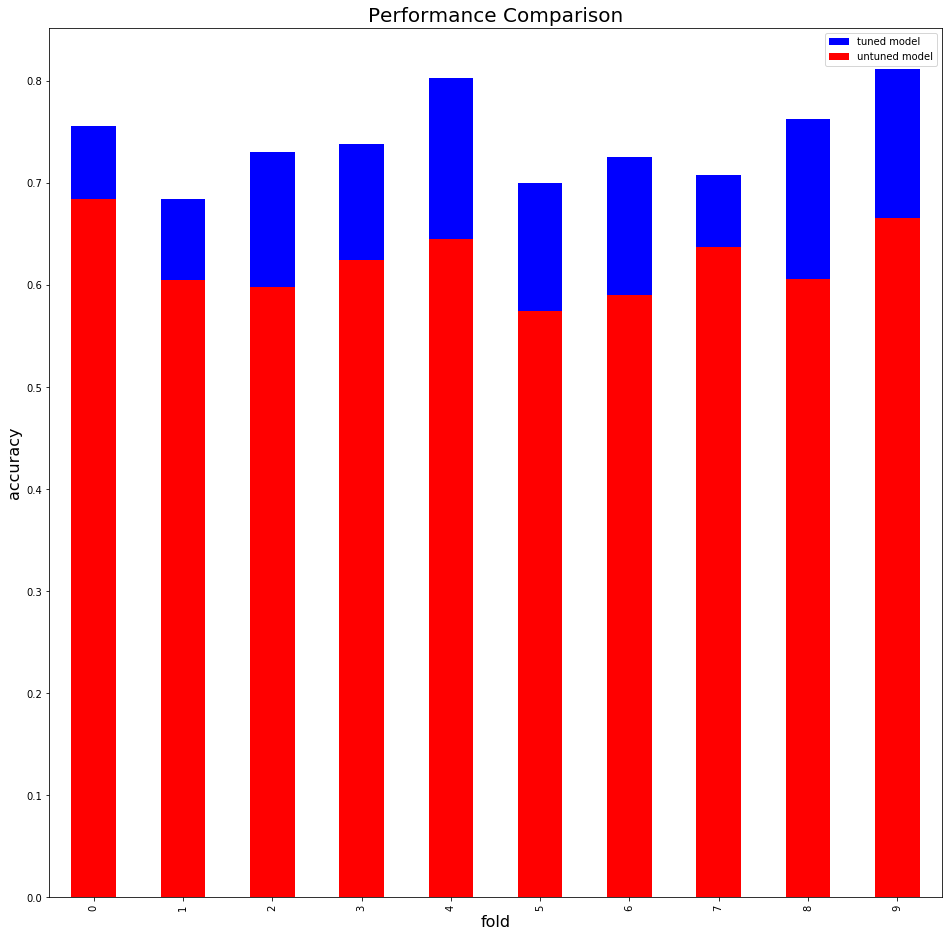

In [58]:
tuned_metrics[1].plot(kind = 'bar', color = 'blue', figsize = (16,16))
untuned_metrics[1].plot(kind = 'bar', color = 'red')
plt.ylabel('accuracy', fontsize = 16)
plt.xlabel('fold', fontsize = 16)
plt.title('Performance Comparison', fontsize = 20)
plt.legend(['tuned model', 'untuned model'])

## Conclusion

Our final tuned model had an accuracy of 78.36%, which performed much better than the 65.78% accuracy obtained by our benchmark model. Based on the improvement of 12.58% in our multi-class classification accuracy, the final tuned model can be deemed as a satisfactory solution.

Moreover, according to the latest publication on the dataset's website, the state-of-the-art mean accuracy achieved for classification was 79%, which was achieved with extensive audio specific data augmentation, and without augmentation their top accuracy was 74%.

Since, we have not used any data augmentation method, our model easily performs better than the accuracy of 74% achieved by the state-of-the-art model. More impressive is the fact that even without using any data augmentation, our models performance is only 0.64% worse than that of the state-of-the-art models performance with augmentation. This further reaffirms that our model is performing well.
